In [ ]:
!python3 -m pip install imgaug
# restart kernel after

In [1]:
import os
import sys
import datetime
import matplotlib.pyplot as plt
import shutil 
import zipfile
import skimage.io
import cv2
import time

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# Import glomerulus
sys.path.append(ROOT_DIR+'/Code') 
import glomerulus

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [3]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "Data/glomerulus")

# Inference Configuration
config = glomerulus.GlomerulusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [4]:
model = modellib.MaskRCNN(mode="inference",
                          model_dir=LOGS_DIR,
                          config=config)
weights_path = model.find_last()
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  /home/jupyter/Segmenting-Histology-Images/logs/glomerulus20200327T1411/mask_rcnn_glomerulus_0045.h5
Re-starting from epoch 45


In [6]:
# Load test dataset
dataset = glomerulus.GlomerulusDataset()
dataset.load_glomerulus(DATASET_DIR, "test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 1
Classes: ['BG', 'glomerulus']


In [7]:
RESULTS_DIR = os.path.join(ROOT_DIR, "results/")
subset = "test"
dataset_dir = DATASET_DIR

if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
submit_dir = "{}_detect_{:%Y%m%dT%H%M%S}".format(subset,datetime.datetime.now())
submit_dir = os.path.join(RESULTS_DIR, submit_dir)
os.makedirs(submit_dir)

In [8]:
image_id=0
image = dataset.load_image(image_id)
img_name = dataset.image_info[image_id]["id"]

In [9]:
t_start = time.time()
r = model.detect([image], verbose=0)[0]
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))


Total time: 27.1 seconds


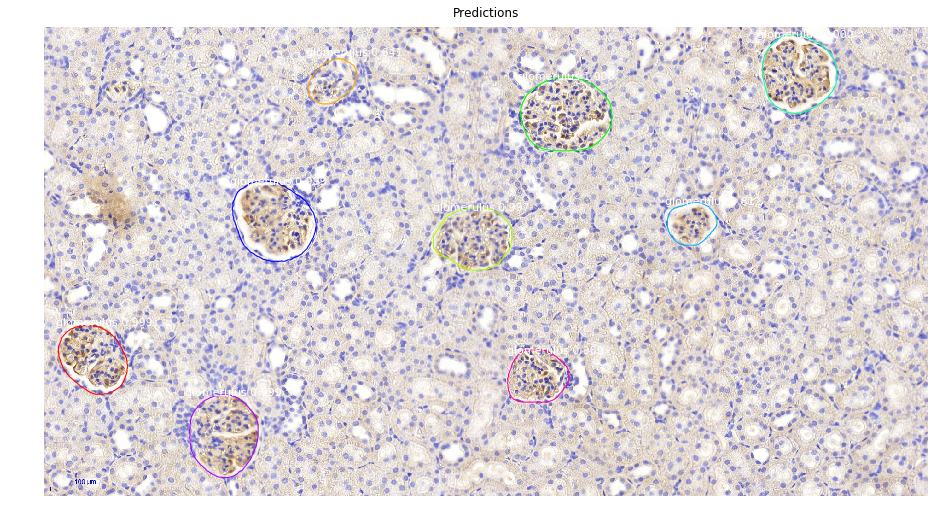

In [10]:
visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")

In [11]:
subset_dir = os.path.join(dataset_dir,subset)
img_dir = os.path.join(submit_dir,img_name)
os.makedirs(img_dir)
img_subdir = os.path.join(img_dir,"images")
os.makedirs(img_subdir)
shutil.copyfile(dataset.image_info[image_id]["path"], os.path.join(img_subdir,img_name+".jpg"))
mask_dir = os.path.join(img_dir,"masks")
os.makedirs(mask_dir)
roi_dir = os.path.join(img_dir,"rois")
os.makedirs(roi_dir)

In [12]:
for i in range(r['masks'].shape[2]): # shape = (h)x(w)x(number of masks)
    mask = (r['masks'][:,:,i]*255).astype('uint8')
    mask_name = "{}-{}".format(img_name,i+1)
    skimage.io.imsave("{}/{}.png".format(mask_dir, mask_name),mask)

    # extract roi from mask
    cnt = glomerulus.contour_from_mask(mask)
    roi = glomerulus.roi_from_contour(mask_name+'.roi',cnt)
    bytes = glomerulus.bytes_from_roi(roi)
    with open(os.path.join(roi_dir,mask_name+'.roi'), "wb") as file:
        file.write(bytes)


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:141: UserWarning: /home/jupyter/Segmenting-Histology-Images/results/test_detect_20200331T151753/R29 VEGF 2_15.0xC3/masks/R29 VEGF 2_15.0xC3-5.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:141: UserWarning: /home/jupyter/Segmenting-Histology-Images/results/test_detect_20200331T151753/R29 VEGF 2_15.0xC3/masks/R29 VEGF 2_15.0xC3-6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:141: UserWarning: /home/jupyter/Segmenting-Histology-Images/results/test_detect_20200331T151753/R29 VEGF 2_15.0xC3/masks/R29 VEGF 2_15.0xC3-7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:141: UserWarning: /home/jupyter/Segmenting-Histology-Images/results/test_detect_20200331T151753/R29 VEGF 2_15.0xC3/masks/R29 VE

In [13]:
with zipfile.ZipFile(os.path.join(img_subdir,img_name + '_roi.zip'), 'w') as zipObj:
    # Add multiple files to the zip
    for file in next(os.walk(roi_dir))[2]:
       if file.endswith('.roi'):
           zipObj.write(os.path.join(roi_dir,file),arcname=file)